In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as nnf
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from torchinfo import summary

from utils.datasets import MNIST_SR

from tqdm import tqdm

import matplotlib.pyplot as plt

from models.prediction.HVAE import HVAE

from utils.metrics import validation_scores

cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
path = "MNIST_HVAE_divers.pth"

x_dim = 32

scale_factor = 4
x_inp_dim  = int(x_dim / scale_factor)


# # hidden_dim = 500
latent_dim = 20

# lr = 1e-3
epochs = 100
batch_size = 2048
batch_size_test = 128

train_dataset = MNIST_SR(split="train", scale_factor=scale_factor)
test_dataset = MNIST_SR(split="test", scale_factor=scale_factor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [3]:
in_channels = 1
channels = [16, 32, 64, 128]
latent_dims = [8,8,8]

model = HVAE(in_channels=in_channels, channels=channels, latent_dims=latent_dims, base_width=x_inp_dim).to(DEVICE)
summary(model, input_size=(1,in_channels, x_inp_dim, x_inp_dim))

Layer (type:depth-idx)                   Output Shape              Param #
HVAE                                     [1, 1, 32, 32]            --
├─HVAELREncoder: 1-1                     [1, 8]                    --
│    └─Conv2d: 2-1                       [1, 16, 8, 8]             32
│    └─Conv2d: 2-2                       [1, 32, 4, 4]             8,224
│    └─Conv2d: 2-3                       [1, 64, 2, 2]             32,832
│    └─Linear: 2-4                       [1, 8]                    2,056
│    └─Linear: 2-5                       [1, 8]                    2,056
│    └─Linear: 2-6                       [1, 8]                    4,104
│    └─Linear: 2-7                       [1, 8]                    4,104
│    └─Linear: 2-8                       [1, 8]                    8,200
│    └─Linear: 2-9                       [1, 8]                    8,200
├─Linear: 1-2                            [1, 8]                    72
├─Linear: 1-3                            [1, 8]             

In [4]:
def loss_function(x, x_hat, latents):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = 0
    for mu, logvar in latents:
        KLD += -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (reproduction_loss + KLD) / x.size(0)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, threshold=0.0001)

In [5]:
model_loss = []

In [6]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        HR, LR = batch

        SR, latents = model(LR)
        # mean, log_var = latents[0]
        loss = loss_function(HR, SR, latents)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print("\tEpoch", epoch, "complete!", "\tAverage Loss: ", overall_loss)

    model_loss.append(overall_loss)
    scheduler.step(overall_loss)

print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss)
print("Finish!!")

Start training VAE...
	Epoch 0 complete! 	Average Loss:  12584.85595703125
	Epoch 10 complete! 	Average Loss:  4745.321762084961
	Epoch 20 complete! 	Average Loss:  4463.47624206543
	Epoch 30 complete! 	Average Loss:  4383.995513916016
	Epoch 40 complete! 	Average Loss:  4337.674301147461
	Epoch 50 complete! 	Average Loss:  4315.5938720703125
	Epoch 60 complete! 	Average Loss:  4291.242813110352
	Epoch 70 complete! 	Average Loss:  4281.631591796875
	Epoch 80 complete! 	Average Loss:  4267.619491577148
	Epoch 90 complete! 	Average Loss:  4257.844207763672
	Epoch 100 complete! 	Average Loss:  4249.319961547852
Finish!!


[]

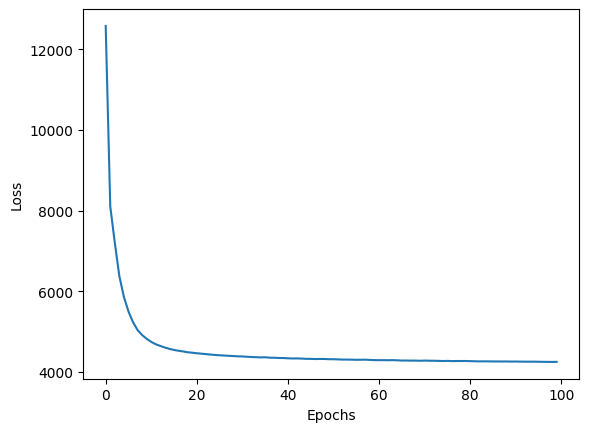

In [7]:
plt.plot(model_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.yscale('log')
plt.plot()

In [8]:
HR, LR = test_dataset.get_samples(1000)
SR = model.sample(LR)

In [9]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

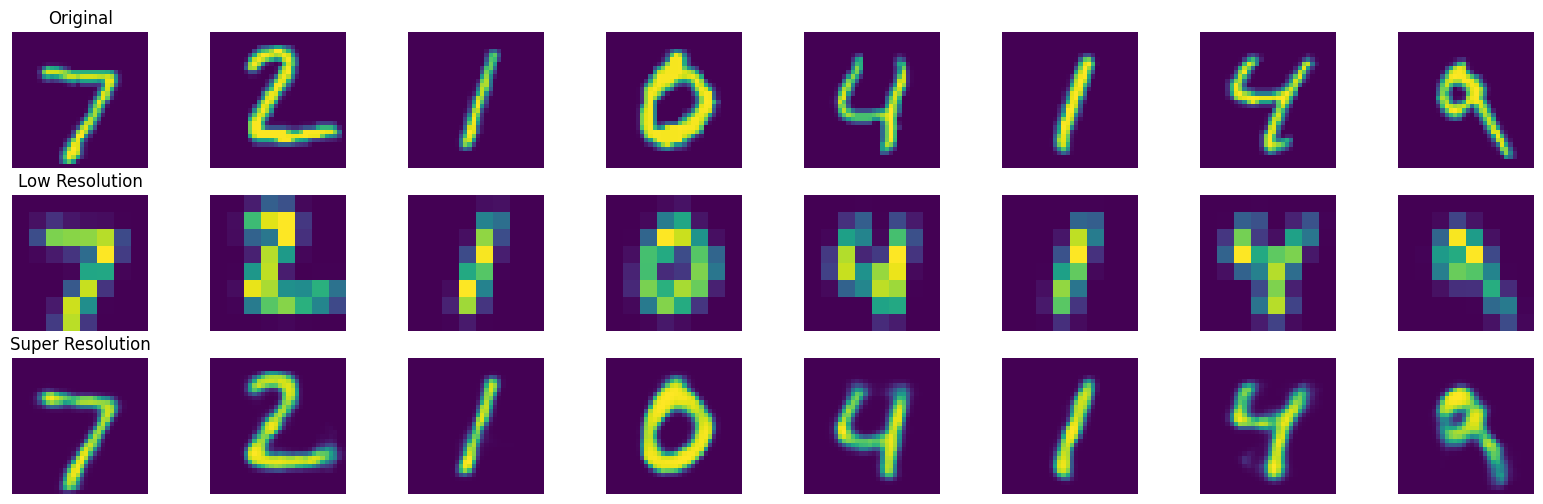

In [10]:
show_image(HR, LR, SR, 8)

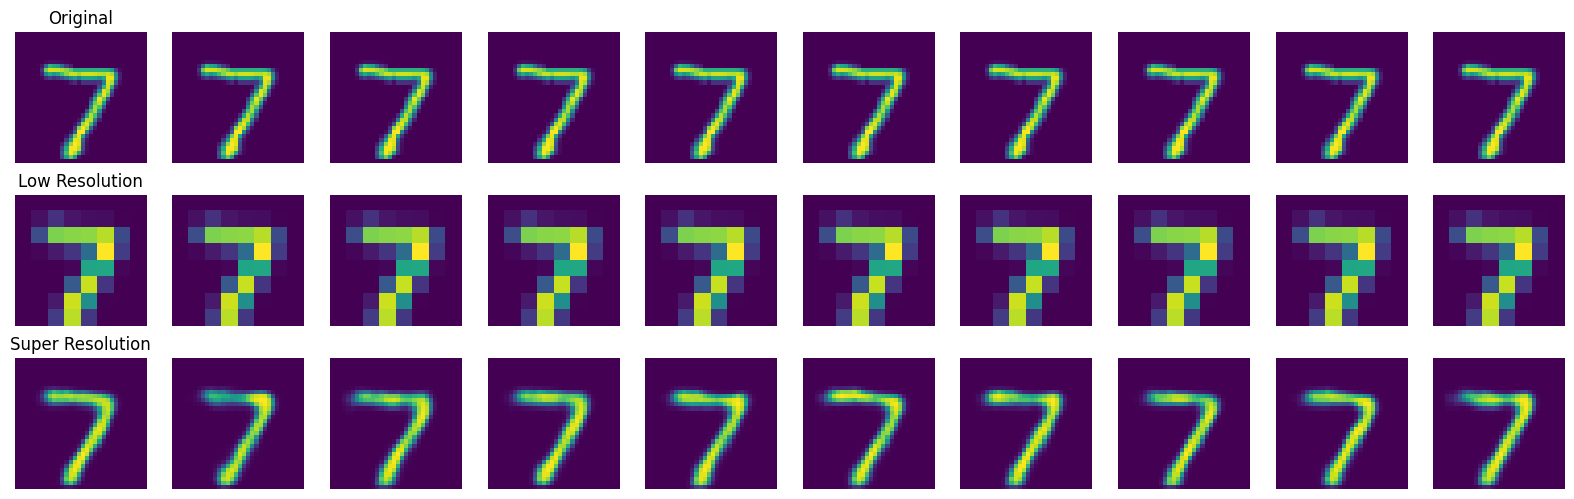

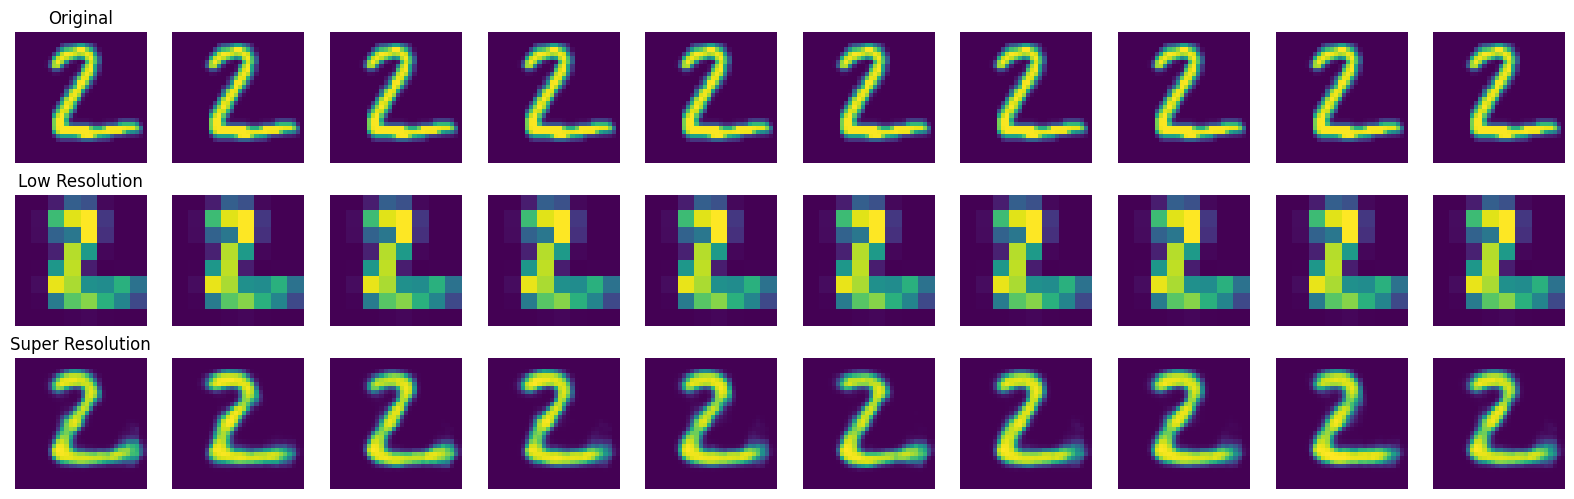

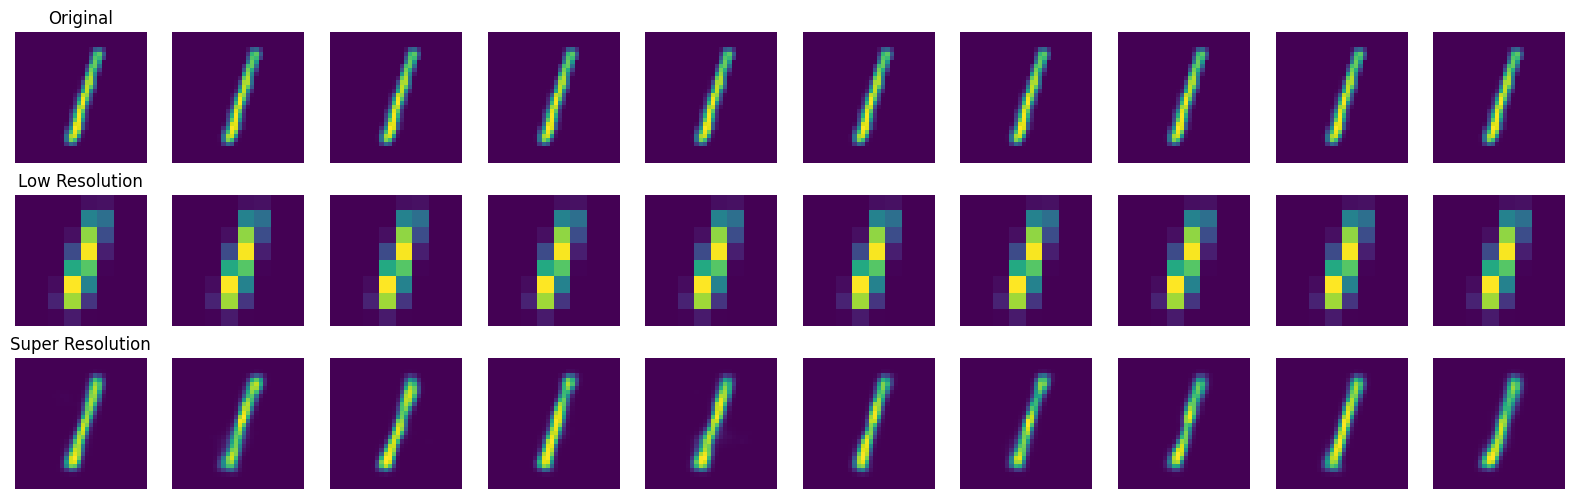

In [11]:
n_samp = 3

for i in range(n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

In [12]:
# save model
torch.save(model.state_dict(), path)

In [13]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [14]:
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("MSE:", mse_val)
print("Perceptual:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MSE: 0.008220420219004154
Perceptual: 1.5964280366897583
PSNR: 21.46268081665039
SSIM: 0.854792058467865
LPIPS: 0.07689853757619858
BRISQUE: 74.71464538574219
PSNR Consistency: 31.319032669067383
MSE Diversity: 0.002554954147854005
LPIPS Diversity: 0.021460528958414216
